# Проект Маркетинг

## Описание

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

### Цель

Предсказать вероятность покупки в течение 90 дней

### Задачи

● Изучить данные  
● Разработать полезные признаки  
● Создать модель для классификации пользователей  
● Улучшить модель и максимизировать метрику roc_auc  
● Выполнить тестирование  

### Данные

apparel-purchases  
история покупок  
● client_id идентификатор пользователя  
● quantity количество товаров в заказе  
● price цена товара  
● category_ids вложенные категории, к которым отнсится товар  
● date дата покупки  
● message_id идентификатор сообщения из рассылки  

apparel-messages  
история рекламных рассылок  
● bulk_campaign_id идентификатор рекламной кампании  
● client_id идентификатор пользователя  
● message_id идентификатор сообщений  
● event тип действия  
● channel канал рассылки  
● date дата рассылки  
● created_at точное время создания сообщения  

apparel-target_binary  
совершит ли клиент покупку в течение следующих 90 дней  
● client_id идентификатор пользователя  
● target целевой признак  


## Подготовка к работе

### Импорты

In [1]:
# === Стандартная библиотека ===
import logging
import warnings
from datetime import datetime

# === Научный стек ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Визуализация пропусков ===
import missingno as msno

# === IPython / Jupyter ===
from tqdm import tqdm
from IPython.display import HTML, display

# === Статистика ===
from phik import phik_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

# === Sklearn ===
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    RobustScaler,
    FunctionTransformer,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    KFold,
    cross_val_score,
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    roc_auc_score,
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# === ML-библиотеки ===
from lightgbm import (
    LGBMClassifier,
    early_stopping as lgb_early_stopping,
    log_evaluation as lgb_log_evaluation,
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import xgboost as xgb

# === Optuna ===
import optuna
from optuna import Study
from optuna.integration.sklearn import OptunaSearchCV
from optuna.integration import (
    XGBoostPruningCallback,
    CatBoostPruningCallback
)
import optuna.integration.lightgbm as lgb_opt
import optuna.integration.catboost as cat_opt

# === Функции проекта ===
from func import (
    EarlyStoppingCallback,
    check_data,
    parse_category_ids,
    plot_combined,
    calc_target_correlations,
    suggest_param,
)

# === Настройки ===
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    module="sklearn.feature_selection._univariate_selection",
)
logging.getLogger("sklearn").setLevel(logging.ERROR)
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option("display.max_columns", None)

xgb_params = {"verbosity": 0}

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

warnings.filterwarnings("ignore", category=UserWarning, module="shap")

### Константы

In [2]:
RANDOM_STATE = 20
TEST_SIZE = 0.25
N_JOBS = -1
N_ITER = 10000 # число итераций для перебора и поиска лучших параметров
N_CROSS_VALL = 5
EARLY_STOP = 200

### Функции

## EDA

### Подключим и почитаем данные

In [3]:
app_msg = pd.read_csv("../data/apparel-messages.csv")
app_prch = pd.read_csv("../data/apparel-purchases.csv")
app_target = pd.read_csv("../data/apparel-target_binary.csv")
event_type = pd.read_csv("../data/full_campaign_daily_event.csv")
event_chanel = pd.read_csv("../data/full_campaign_daily_event_channel.csv")

### Первичная оценка и обработка данных

#### app_msg

In [4]:
app_msg = check_data(app_msg)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
6745339,13598,1515915625487909209,1515915625487909209-13598-64ce2be3bc4b2,send,mobile_push,2023-08-05,2023-08-05 11:04:10
9595656,14172,1515915625489961834,1515915625489961834-14172-655ef709d5012,send,mobile_push,2023-11-23,2023-11-23 07:01:35
7007044,13660,1515915625468242324,1515915625468242324-13660-64dc80a798947,send,email,2023-08-16,2023-08-16 09:07:10
9139479,14081,1515915625559613624,1515915625559613624-14081-654db94346cef,open,mobile_push,2023-11-10,2023-11-10 06:36:27
6109139,13464,1515915625565452906,1515915625565452906-13464-64a81a93e6030,send,mobile_push,2023-07-07,2023-07-07 14:11:34


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
bulk_campaign_id,12739798.0,1.160459e+04,3.259211e+03,5.480000e+02,8.746000e+03,1.351600e+04,1.415800e+04,1.465700e+04
client_id,12739798.0,1.515916e+18,1.329704e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18


In [5]:
# посмотрим дату начала и конца событий
first_date = app_msg['date'].min()
last_date = app_msg['date'].max()
display(first_date)
display(last_date)

'2022-05-19'

'2024-02-15'

In [6]:
# посмотрим уники среди событий и канал распространения
display(app_msg['event'].unique())
display(app_msg['channel'].unique())

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

array(['email', 'mobile_push'], dtype=object)

Что имеем:  
open — письмо открыто  
click — клик по ссылке в письме  
purchase — покупка после перехода из письма  
send — отправка письма  
unsubscribe — отписка от рассылки  
hbq_spam — сообщение отмечено как спам  
hard_bounce — письмо не доставлено из-за постоянной ошибки (адрес не существует)  
subscribe — подписка на рассылку  
soft_bounce — письмо не доставлено из-за временной ошибки (ящик переполнен, сервер недоступен)  
complain — жалоба пользователя (напр. “Это спам”)  
close — завершение сессии (иногда: закрытие письма или вкладки)  

In [7]:
# посмотри число дубликатов в базе
app_msg.duplicated().sum()

np.int64(48610)

Вот тут тонкий момент:  
1) Это косяк базы и надо просто удалить дубликаты и забыть про них;  
2) Сомнения имею я, что это косяк и скорее всего это спамер просто отправил несколько мессаг и тогда из этого можно сделать бинарную фичу, что-то типа "spam_factor"

In [8]:
# проверим сколько уникальных клиентов
display(app_msg['client_id'].nunique())

53329

Из 12.739.798 строк мы имеем 53.329 уникальных клиентов.  
Нужна будет пересборка данных с агрегацией

Выводы:  
Самая объемная база.  
Столбцы  date, created_at имеют неверный формат данных - необходимо будет преобразовать.


#### app_prch

In [9]:
app_prch = check_data(app_prch)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

,client_id,quantity,price,category_ids,date,message_id
84219,1515915625557050366,1,10.0,[],2023-01-30,1515915625559937153-9601-63d0ee12c0010
86832,1515915625585548339,1,279.0,"['5562', '5631', '5670', '612']",2023-03-02,1515915625505015125-10567-6400609601314
15409,1515915625572575545,1,2799.0,"['4', '28', '49', '413']",2022-06-19,1515915625572575545-4981-62ac2daa388fd
46111,1515915625506855397,1,2449.0,"['4', '28', '249', '616']",2022-11-11,1515915625506855397-7810-636e58f8b1866
108261,1515915625952369437,1,2449.0,"['2', '18', '258', '441']",2023-04-20,1515915625952369437-11968-643eaee34d55c


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
client_id,202208.0,1.515916e+18,1.459458e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
quantity,202208.0,1.006483e+00,1.843837e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+01
price,202208.0,1.193302e+03,1.342253e+03,1.000000e+00,3.520000e+02,9.870000e+02,1.699000e+03,8.549900e+04


In [10]:
# проверим сколько уникальных клиентов совершило покупки
display(app_prch['client_id'].nunique())

49849

In [11]:
display(app_prch['client_id'].nunique() / app_msg['client_id'].nunique())

0.934744698006713

Т.е. после всех событий произвели покупку 93.4% уникальных пользователей в текущей выборке, и почти 7% проигнорировало.  
В целом это очень хороший показатель.

In [12]:
# и еще посмотрим категории
app_prch[app_prch['category_ids'] == '[]']

,client_id,quantity,price,category_ids,date,message_id
22153,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
22154,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
49215,1515915625474537721,1,7.0,[],2022-11-12,1515915625474537721-7803-636dfed5eb8b6
53223,1515915625720375281,1,5.0,[],2022-11-13,1515915625720375281-7818-636f6ec29a382
59056,1515915625867975448,1,7.0,[],2022-11-16,1515915625766044118-7879-63748749d81b5
...,...,...,...,...,...,...
201990,1515915625641742458,1,7.0,[],2024-02-16,1515915625766077627-14668-65cf5246bd490
202068,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c
202069,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c
202144,1515915626007712189,1,12.0,[],2024-02-16,1515915626007712189-14648-65cdb6d1c0c2a


2025-10-05 11:00:23 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-05 11:00:23 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


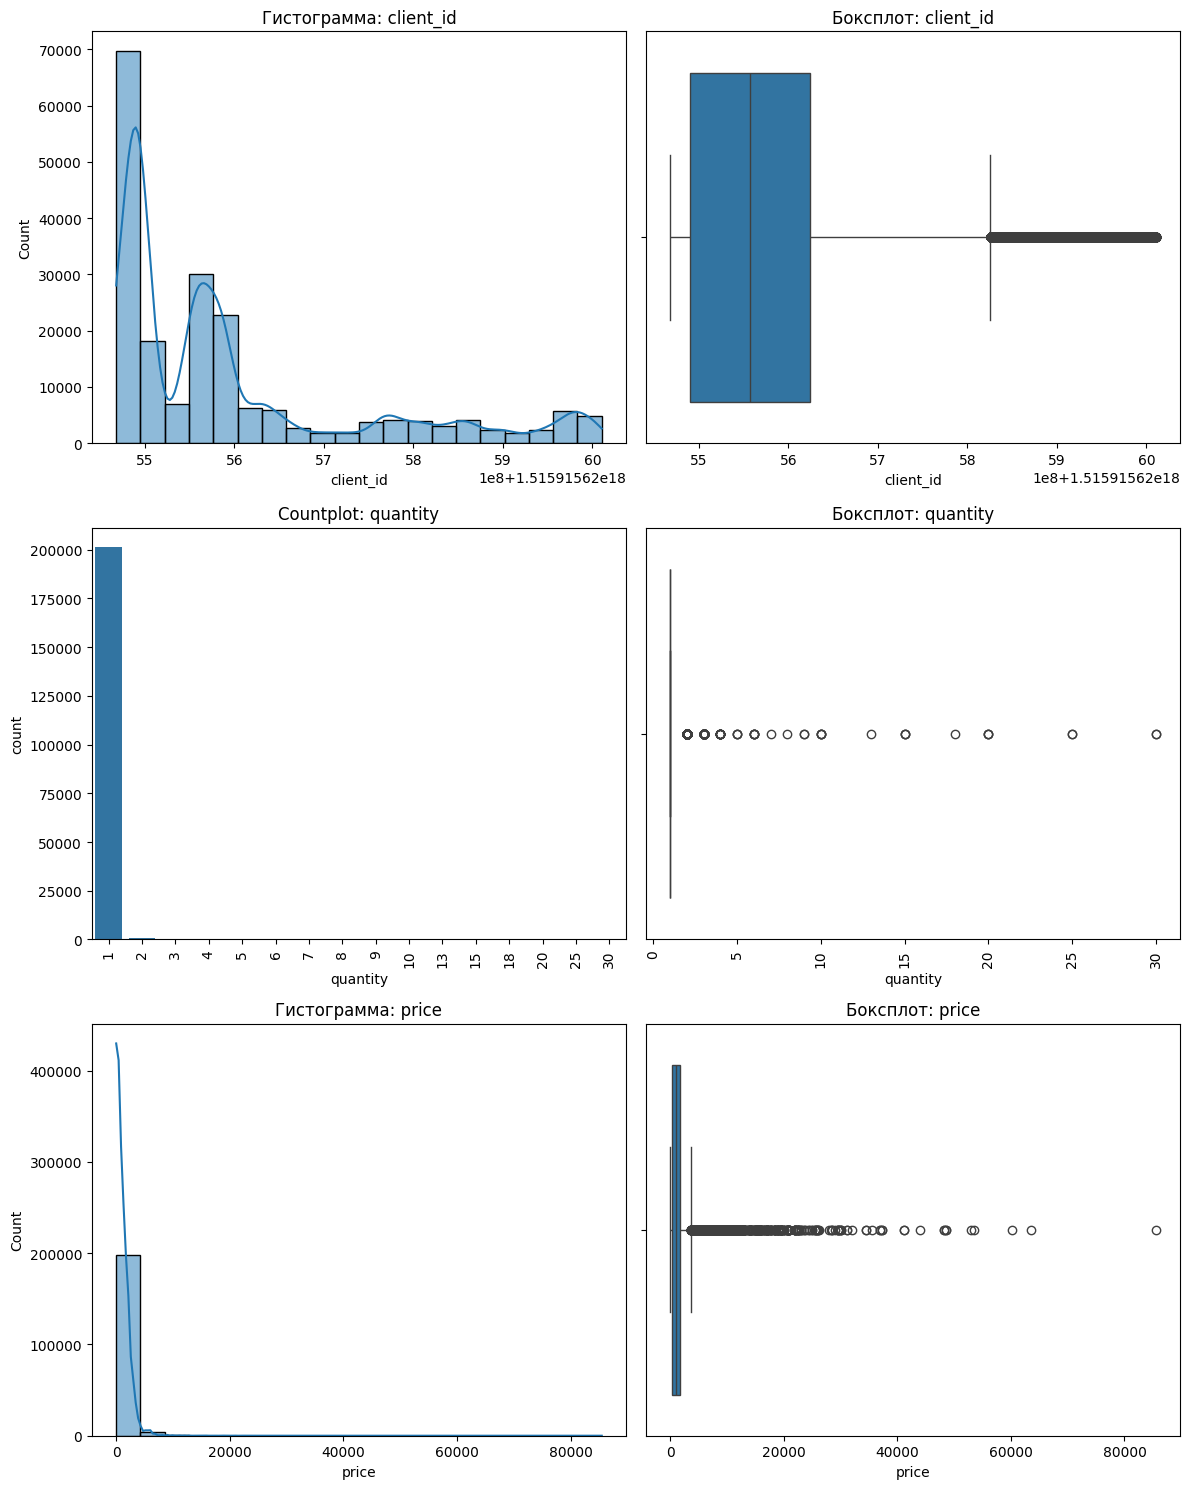

In [13]:
# тут еще заодно проведем более глубокий анализ данных
plot_combined(app_prch, col=None, target=None, col_type=None, legend_loc='best')

In [14]:
# здесь нам интересно глянуть цены, сколько нулей и где
app_prch[app_prch['price'] < 3]

,client_id,quantity,price,category_ids,date,message_id
20226,1515915625558928490,1,2.0,"['5562', '5597', '5691', '889']",2022-07-06,1515915625558928490-5286-62c52c06da8ee
21424,1515915625559762595,10,2.0,"['5562', '5597', '5691', '889']",2022-07-08,1515915625471544776-5335-62c7d2c4cc9fd
21425,1515915625559762595,10,2.0,"['5562', '5597', '5691', '889']",2022-07-08,1515915625471544776-5335-62c7d2c4cc9fd
22153,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
22154,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
...,...,...,...,...,...,...
199858,1515915625648416429,1,2.0,[],2024-02-09,1515915625648416429-14627-65c64f90a6f73
199859,1515915625648416429,1,2.0,[],2024-02-09,1515915625648416429-14627-65c64f90a6f73
201246,1515915625558967191,1,1.0,[],2024-02-14,1515915625980158750-14649-65cca1c3cc334
201247,1515915625558967191,1,1.0,[],2024-02-14,1515915625980158750-14649-65cca1c3cc334


Нулевых нет, уже хорошо.  
Ну, а цена в одну единицу в целом бывает.  
Также видим, что появились непонятные категории - пустые или None, что тоже не очень хорошо, но их обработает дальше.

Выводы:  
Столбец  date имеет неверный формат данных - необходимо будет преобразовать.  
Столбец category_ids - тут 2 варианта развития событий:  
- возьмем только глобальную категорию и конкретный товар, т.е. 1е и последнее значение;  
- можно будет преобразовывать в разряженную матрица, т.к. небольшой объем данных  
ну и потом с такой матрицей умеет работать xgboost который и будем использовать в предсказаниях;

#### app_target

In [15]:
app_target = check_data(app_target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

,client_id,target
10483,1515915625489271290,0
34855,1515915625590775798,0
18498,1515915625500239273,0
30836,1515915625576171248,0
27743,1515915625559803600,0


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
client_id,49849.0,1.515916e+18,1.487947e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
target,49849.0,1.927822e-02,1.375025e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


Выводы:  
Ну тут все понятно, обсуждать нечего

#### event_type

In [16]:
event_type = check_data(event_type)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

None

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
38878,2022-12-01,6251,0,0,0,25,0,0,0,0,1,0,0,0,25,0,0,0,0,1,0,0,0,0
113438,2024-03-04,13660,0,0,0,7,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0
11224,2022-07-24,4052,0,0,0,44,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0
8013,2022-07-07,2947,1,0,0,20,0,0,0,0,1,1,0,0,16,0,0,0,0,1,0,0,0,0
114768,2024-03-09,14757,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
bulk_campaign_id,131072.0,8416.743378,4877.369306,548.0,4116.0,7477.0,13732.0,15150.0
count_click,131072.0,90.982971,1275.503564,0.0,0.0,0.0,2.0,128453.0
count_complain,131072.0,0.932655,30.198326,0.0,0.0,0.0,0.0,5160.0
count_hard_bounce,131072.0,78.473434,1961.317826,0.0,0.0,0.0,0.0,287404.0
count_open,131072.0,3771.090691,65160.668444,0.0,1.0,6.0,30.0,5076151.0
count_purchase,131072.0,0.577927,9.107040,0.0,0.0,0.0,0.0,1077.0
count_send,131072.0,11634.142319,175709.508290,0.0,0.0,0.0,0.0,11543513.0
count_soft_bounce,131072.0,27.807312,736.944714,0.0,0.0,0.0,0.0,76284.0
count_subscribe,131072.0,0.140518,2.072777,0.0,0.0,0.0,0.0,189.0
count_unsubscribe,131072.0,6.362679,79.172069,0.0,0.0,0.0,1.0,9089.0


Вывод:  
Здесь просто агрегированная статистика по событиям, не вижу смысла, что-то делать с этой таблицей в принципе

#### event_chanel

In [17]:
event_chanel = check_data(event_chanel)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

None

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
6465,2022-06-29,1140,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29149,2022-10-20,7131,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70297,2023-04-27,12183,0,351,0,3636,0,26,0,0,0,0,351,0,3604,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22565,2022-09-19,6316,230,0,3221,0,0,0,0,3,99,163,0,3010,0,0,0,0,3,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13285,2022-08-04,3249,1,0,8,0,0,0,0,0,0,1,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
bulk_campaign_id,131072.0,8416.743378,4877.369306,548.0,4116.0,7477.0,13732.0,15150.0
count_click_email,131072.0,41.582169,745.484035,0.0,0.0,0.0,1.0,59365.0
count_click_mobile_push,131072.0,49.400803,1036.952898,0.0,0.0,0.0,0.0,128453.0
count_open_email,131072.0,423.706032,9753.383722,0.0,1.0,5.0,23.0,2597015.0
count_open_mobile_push,131072.0,3347.384659,64448.590783,0.0,0.0,0.0,0.0,5076151.0
count_purchase_email,131072.0,0.357483,8.287483,0.0,0.0,0.0,0.0,1077.0
count_purchase_mobile_push,131072.0,0.220444,3.796500,0.0,0.0,0.0,0.0,431.0
count_soft_bounce_email,131072.0,24.474823,727.069387,0.0,0.0,0.0,0.0,76284.0
count_subscribe_email,131072.0,0.140518,2.072777,0.0,0.0,0.0,0.0,189.0
count_unsubscribe_email,131072.0,6.362679,79.172069,0.0,0.0,0.0,1.0,9089.0


Вывод:  
По сути своей, тоже самое, что и прошлая таблица - статистика по событиям.  
Возможно и есть смысл где-то использовать, но пока непонятно где и как

#### Выводы

Были подгружены и изучены предоставленные данные.  
Глобально, для реализации задачи нам понадобится только 3 таблицы - apparel-messages, apparel-purchases и apparel-target_binary, т.к. эти таблицы несут основную смысловую нагрузку.  
Две оставшиеся таблицы - статистика по ивентам и активности пользователей без привязки к этим самым пользователям и ничего нам не дадут.  



## Предобработка данных

### Обработка имеющихся данных

In [18]:
# преобразуем даты
app_msg["date"] = pd.to_datetime(app_msg["date"], errors="coerce")
app_msg["created_at"] = pd.to_datetime(app_msg["created_at"], errors="coerce")

app_prch["date"] = pd.to_datetime(app_prch["date"], errors="coerce")

### feature engineering

Для начала поработаем с каждой таблицей по отдельности и сделаем, что-то новое.  

app_msg
Что мы можем сделать:  
1) У нас есть дата реакции на ивент и дата создания ивента - скорость реакции на ивент, потом усредняем;  
2) Есть канал и действие - соберем суммарное число действий по каждому каналу;  
3) Сделать бинарную фичу "spam_factor", т.е. берем дубли, смотрим кого заспамили - тем 1, кого нет - 0.  

app_prch  
Что мы можем сделать:  
1) Время с момента последней покупки, сделаем в днях;  
2) Среднее число товаров в заказе;  
3) Средний чек заказа;  
4) Средняя цена итема;  
5) В какой категории больше всего покупок (предварительно разобьем category_ids на top и last id - глобальную категорию и конкретный товар);  
6) Любимый товар;  
7) Любимая категория;  
8) Средний интервал между покупками, в днях;  
9) Дней с последнего взаимодействия с рассылкой;  
10) Сделаем группировку по 30/60/90/180/360 дней, а там агрегируем по числу покупок, числу итемов, сумме затрат от последней имеющейся у нас отчетной даты;  

#### app_msg

In [19]:
app_msg.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [20]:
# У нас есть дата реакции на ивент и дата создания ивента - скорость реакции
app_msg["reaction_for_event"] = (
    (app_msg["date"].dt.normalize() - app_msg["created_at"].dt.normalize())
    .dt.days.astype("int16")
)

In [21]:
app_msg['reaction_for_event'].unique()

array([0], dtype=int16)

Неожиданно, все реагируют на ивенты в тот же день.  
В таком случае этот признак для нас бесполезен

In [22]:
# теперь агрегируем данные
app_msg_agg = (
    app_msg.groupby("client_id")
    .agg(
        bulk_campaigns=("bulk_campaign_id", "nunique"),
        messages=("message_id", "nunique"),
        events=("event", "nunique"),
        channels=("channel", "nunique"),
        first_date=("date", "min"),
        last_date=("date", "max"),
        pop_event=("event", lambda x: x.value_counts().idxmax() if not x.value_counts().empty else "unknown")
    )
    .reset_index()
)

In [23]:
# считаем число действий по каналам и событиям
channel_event_counts = (
    pd.crosstab(
        index=app_msg["client_id"],
        columns=[app_msg["channel"], app_msg["event"]]
    )
)

# делаем имена колонок: actions_{channel}_{event}
channel_event_counts.columns = [
    f"actions_{ch}_{ev}" for ch, ev in channel_event_counts.columns
]

# собираем в кучу
channel_event_counts = channel_event_counts.reset_index()
app_msg_agg = app_msg_agg.merge(channel_event_counts, on="client_id", how="left")

In [24]:
# считаем количество дублей сообщений на юзера
dup_counts = (
    app_msg.groupby("client_id")
    .agg(dup_count=("message_id", lambda x: app_msg.loc[x.index].duplicated().sum()))
    .reset_index()
)

# spam_factor = 1 если дублей >= 2, иначе 0
dup_counts["spam_factor"] = (dup_counts["dup_count"] >= 2).astype(int)

# объединяем с агрегатами
app_msg_agg = app_msg_agg.merge(dup_counts, on="client_id", how="left")
app_msg_agg[["dup_count", "spam_factor"]] = app_msg_agg[["dup_count", "spam_factor"]].fillna(0).astype(int)

In [25]:
app_msg_agg[app_msg_agg["spam_factor"] == 1]

,client_id,bulk_campaigns,messages,events,channels,first_date,last_date,pop_event,actions_email_click,actions_email_complain,actions_email_hard_bounce,actions_email_hbq_spam,actions_email_open,actions_email_purchase,actions_email_send,actions_email_soft_bounce,actions_email_subscribe,actions_email_unsubscribe,actions_mobile_push_click,actions_mobile_push_close,actions_mobile_push_hard_bounce,actions_mobile_push_open,actions_mobile_push_purchase,actions_mobile_push_send,actions_mobile_push_soft_bounce,dup_count,spam_factor
3,1515915625468061100,265,268,6,1,2022-05-19,2024-02-15,send,0,0,0,0,0,0,0,0,0,0,1,0,1,163,1,267,1,6,1
9,1515915625468061994,339,346,4,2,2022-05-25,2024-02-14,send,0,0,0,0,0,0,96,0,0,0,11,0,0,21,2,250,0,2,1
10,1515915625468062158,113,113,4,1,2022-05-20,2024-02-13,send,31,0,0,0,28,2,113,0,0,0,0,0,0,0,0,0,0,2,1
48,1515915625468064438,219,225,6,2,2022-05-19,2024-02-15,send,120,0,0,0,82,9,145,0,0,0,2,0,1,78,0,79,1,2,1
53,1515915625468064943,288,291,5,2,2022-05-19,2024-02-15,send,3,0,0,0,7,2,150,0,0,0,1,0,2,142,0,141,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53218,1515915626008498025,10,10,5,1,2024-01-22,2024-02-14,open,0,0,0,0,0,0,0,0,0,0,3,0,1,14,1,10,0,3,1
53219,1515915626008514147,4,4,4,1,2024-01-22,2024-02-02,click,0,0,0,0,0,0,0,0,0,0,7,0,0,4,2,4,0,2,1
53225,1515915626008582277,1,1,3,1,2024-01-22,2024-02-10,click,0,0,0,0,0,0,0,0,0,0,19,0,0,1,0,1,0,5,1
53248,1515915626009118362,4,4,5,1,2024-01-28,2024-02-14,click,0,0,0,0,0,0,0,0,0,0,7,0,1,3,2,4,0,2,1


In [26]:
display(app_msg_agg.head())
display(app_msg_agg.info())

,client_id,bulk_campaigns,messages,events,channels,first_date,last_date,pop_event,actions_email_click,actions_email_complain,actions_email_hard_bounce,actions_email_hbq_spam,actions_email_open,actions_email_purchase,actions_email_send,actions_email_soft_bounce,actions_email_subscribe,actions_email_unsubscribe,actions_mobile_push_click,actions_mobile_push_close,actions_mobile_push_hard_bounce,actions_mobile_push_open,actions_mobile_push_purchase,actions_mobile_push_send,actions_mobile_push_soft_bounce,dup_count,spam_factor
0,1515915625468060902,127,127,5,1,2022-05-19,2024-01-19,send,10,0,0,0,35,5,126,0,0,1,0,0,0,0,0,0,0,0,0
1,1515915625468061003,154,154,4,1,2022-05-20,2024-02-13,send,6,0,0,0,5,1,154,0,0,0,0,0,0,0,0,0,0,1,0
2,1515915625468061099,215,215,4,2,2022-05-19,2024-02-13,send,8,0,0,0,17,0,157,0,0,0,0,0,2,34,0,58,0,0,0
3,1515915625468061100,265,268,6,1,2022-05-19,2024-02-15,send,0,0,0,0,0,0,0,0,0,0,1,0,1,163,1,267,1,6,1
4,1515915625468061170,240,243,4,2,2022-05-25,2024-02-15,send,16,0,0,0,19,3,164,0,0,0,0,0,0,12,0,79,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   client_id                        53329 non-null  int64         
 1   bulk_campaigns                   53329 non-null  int64         
 2   messages                         53329 non-null  int64         
 3   events                           53329 non-null  int64         
 4   channels                         53329 non-null  int64         
 5   first_date                       53329 non-null  datetime64[ns]
 6   last_date                        53329 non-null  datetime64[ns]
 7   pop_event                        53329 non-null  object        
 8   actions_email_click              53329 non-null  int64         
 9   actions_email_complain           53329 non-null  int64         
 10  actions_email_hard_bounce        53329 non-null  int64    

None

Выглядит жутко, но мы закрываем глаза и продолжаем делать :)

#### app_prch

In [27]:
# начнем с разбора category_ids
# превращаем в списки category_ids
app_prch["category_ids"] = app_prch["category_ids"].apply(parse_category_ids)

# берём первую категорию
app_prch["category_ids_top"] = app_prch["category_ids"].apply(
    lambda x: int(x[0]) if len(x) > 0 and str(x[0]).isdigit() else -1
).astype("int16")

# берём последнюю непустую категорию
app_prch["category_ids_last"] = app_prch["category_ids"].apply(
    lambda x: int(next((i for i in reversed(x) if i not in [None, "", "nan"] and str(i).isdigit()), -1))
).astype("int16")

In [28]:
# время с момента последней покупки (в днях)
last_date = pd.to_datetime(last_date)

last_purchase = (
    app_prch.groupby("client_id")["date"].max()
    .reset_index(name="last_purchase_date")
)

last_purchase["days_from_last_purchase"] = (
    (last_date - last_purchase["last_purchase_date"]).dt.days.astype("int16")
)
last_purchase.head()

,client_id,last_purchase_date,days_from_last_purchase
0,1515915625468060902,2022-05-27,629
1,1515915625468061003,2023-01-04,407
2,1515915625468061099,2022-05-17,639
3,1515915625468061100,2024-02-10,5
4,1515915625468061170,2023-06-17,243


In [29]:
# среднее число товаров в заказе
avg_items_per_order = (
    app_prch.groupby(["client_id", "message_id"])["quantity"].sum()
    .groupby("client_id").median()
    .reset_index(name="avg_items_per_order")
)
avg_items_per_order.head()

,client_id,avg_items_per_order
0,1515915625468060902,7.0
1,1515915625468061003,7.0
2,1515915625468061099,1.0
3,1515915625468061100,2.0
4,1515915625468061170,4.0


In [30]:
# средний чек заказа
avg_order_sum = (
    app_prch.groupby(["client_id", "message_id"])
    .apply(lambda df: (df["quantity"] * df["price"]).sum(), include_groups=False)
    .groupby("client_id").mean()
    .reset_index(name="avg_order_sum")
)
avg_order_sum.head()

,client_id,avg_order_sum
0,1515915625468060902,6993.000000
1,1515915625468061003,16235.000000
2,1515915625468061099,299.000000
3,1515915625468061100,2098.000000
4,1515915625468061170,11200.333333


In [31]:
# средняя цена итема
avg_item_price = (
    (app_prch["price"] * app_prch["quantity"])
    .groupby(app_prch["client_id"]).sum()
    / app_prch.groupby("client_id")["quantity"].sum()
)
avg_item_price = avg_item_price.reset_index(name="avg_item_price")
avg_item_price.head()

,client_id,avg_item_price
0,1515915625468060902,999.000000
1,1515915625468061003,2319.285714
2,1515915625468061099,299.000000
3,1515915625468061100,1049.000000
4,1515915625468061170,1768.473684


In [32]:
# любимая категория (top)
fav_category_top = (
    app_prch.groupby("client_id")["category_ids_top"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else "unknown")
    .reset_index(name="fav_category_top")
)
fav_category_top.head()

,client_id,fav_category_top
0,1515915625468060902,4
1,1515915625468061003,4
2,1515915625468061099,4
3,1515915625468061100,4
4,1515915625468061170,4


In [33]:
# любимый товар (last)
fav_category_last = (
    app_prch.groupby("client_id")["category_ids_last"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else "unknown")
    .reset_index(name="fav_category_last")
)
fav_category_last.head()

,client_id,fav_category_last
0,1515915625468060902,420
1,1515915625468061003,615
2,1515915625468061099,424
3,1515915625468061100,5717
4,1515915625468061170,420


In [34]:
# средний интервал между покупками (в днях)
avg_interval = (
    app_prch.groupby("client_id")["date"]
    .apply(
        lambda x: np.mean(np.diff(np.sort(x.unique())).astype("timedelta64[D]").astype(int))
        if x.nunique() > 1 else -1
    )
    .reset_index(name="avg_interval_days")
)
display(avg_interval.sample(5))
display(avg_interval.describe().T)

,client_id,avg_interval_days
4437,1515915625475400099,-1.000000
3858,1515915625473533863,37.714286
138,1515915625468071652,93.333333
8023,1515915625488375927,-1.000000
40469,1515915625746701777,-1.000000


,count,mean,std,min,25%,50%,75%,max
client_id,49849.0,1.515916e+18,1.487947e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
avg_interval_days,49849.0,1.478866e+01,5.942546e+01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,6.190000e+02


In [35]:
# сумма покупок
lifetime_value = (
    (app_prch["quantity"] * app_prch["price"])
    .groupby(app_prch["client_id"]).sum()
    .reset_index(name="lifetime_value")
)
display(lifetime_value.head())
display(lifetime_value.describe().T)

,client_id,lifetime_value
0,1515915625468060902,6993.0
1,1515915625468061003,16235.0
2,1515915625468061099,299.0
3,1515915625468061100,2098.0
4,1515915625468061170,33601.0


,count,mean,std,min,25%,50%,75%,max
client_id,49849.0,1.515916e+18,1.487947e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
lifetime_value,49849.0,4.865584e+03,7.351467e+03,1.000000e+00,1.499000e+03,2.969000e+03,5.698000e+03,5.404080e+05


In [36]:
# churn-флаг (>360 дней без покупок)
churn_flag = (
    app_prch.groupby("client_id")["date"].max()
    .reset_index(name="last_purchase_date")
)
churn_flag["churn_flag"] = (
    (last_date - churn_flag["last_purchase_date"]).dt.days > 360
).astype("int8")
churn_flag.head()

,client_id,last_purchase_date,churn_flag
0,1515915625468060902,2022-05-27,1
1,1515915625468061003,2023-01-04,1
2,1515915625468061099,2022-05-17,1
3,1515915625468061100,2024-02-10,0
4,1515915625468061170,2023-06-17,0


In [37]:
# агрегации по окнам 30/60/90/180/360 дней
def agg_period(df, cutoff_days, all_clients):
    cutoff = last_date - pd.Timedelta(days=cutoff_days)
    dff = df[df["date"] >= cutoff]
    out = dff.groupby("client_id").agg(
        purchases=("message_id", "nunique"),
        items=("quantity", "sum"),
        cost=("price", lambda x: (dff.loc[x.index, "quantity"] * x).sum())
    )

    out = out.rename(columns={
        "purchases": f"purchases_{cutoff_days}d",
        "items": f"items_{cutoff_days}d",
        "cost": f"cost_{cutoff_days}d"
    })

    # добавляем всех клиентов, которых нет в dff
    out = out.reindex(all_clients, fill_value=0).reset_index()
    return out

all_clients = app_prch["client_id"].unique()
agg_30 = agg_period(app_prch, 30, all_clients)
agg_60 = agg_period(app_prch, 60, all_clients)
agg_90 = agg_period(app_prch, 90, all_clients)
agg_180 = agg_period(app_prch, 180, all_clients)
agg_360 = agg_period(app_prch, 360, all_clients)

agg_360.head()

,client_id,purchases_360d,items_360d,cost_360d
0,1515915625468169594,2,6,18372.0
1,1515915625471138230,0,0,0.0
2,1515915625471640575,0,0,0.0
3,1515915625490211585,0,0,0.0
4,1515915625490739153,0,0,0.0


In [38]:
# объединяем все в единый датафрейм client_features
app_prch_agg = last_purchase[["client_id", "days_from_last_purchase"]] \
    .merge(avg_items_per_order, on="client_id", how="left") \
    .merge(avg_order_sum, on="client_id", how="left") \
    .merge(avg_item_price, on="client_id", how="left") \
    .merge(fav_category_top, on="client_id", how="left") \
    .merge(fav_category_last, on="client_id", how="left") \
    .merge(avg_interval, on="client_id", how="left") \
    .merge(lifetime_value, on="client_id", how="left") \
    .merge(churn_flag[["client_id", "churn_flag"]], on="client_id", how="left") \
    .merge(agg_30, on="client_id", how="left") \
    .merge(agg_60, on="client_id", how="left") \
    .merge(agg_90, on="client_id", how="left") \
    .merge(agg_180, on="client_id", how="left") \
    .merge(agg_360, on="client_id", how="left")

app_prch_agg.head()

,client_id,days_from_last_purchase,avg_items_per_order,avg_order_sum,avg_item_price,fav_category_top,fav_category_last,avg_interval_days,lifetime_value,churn_flag,purchases_30d,items_30d,cost_30d,purchases_60d,items_60d,cost_60d,purchases_90d,items_90d,cost_90d,purchases_180d,items_180d,cost_180d,purchases_360d,items_360d,cost_360d
0,1515915625468060902,629,7.0,6993.000000,999.000000,4,420,-1.0,6993.0,1,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0
1,1515915625468061003,407,7.0,16235.000000,2319.285714,4,615,-1.0,16235.0,1,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0
2,1515915625468061099,639,1.0,299.000000,299.000000,4,424,-1.0,299.0,1,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0
3,1515915625468061100,5,2.0,2098.000000,1049.000000,4,5717,-1.0,2098.0,0,1,2,2098.0,1,2,2098.0,1,2,2098.0,1,2,2098.0,1,2,2098.0
4,1515915625468061170,243,4.0,11200.333333,1768.473684,4,420,41.5,33601.0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,3,19,33601.0


In [39]:
app_prch_agg['client_id'].nunique()

49849

In [40]:
app_msg_agg['client_id'].nunique()

53329

### Финальная таблица

In [41]:
# ну и финально смержим 2 агрегированные таблицы и таблицу с таргетом
df = app_prch_agg.merge(app_msg_agg, on='client_id', how='left')
df = df.merge(app_target, on='client_id', how='left')

In [42]:
display(df.head())

,client_id,days_from_last_purchase,avg_items_per_order,avg_order_sum,avg_item_price,fav_category_top,fav_category_last,avg_interval_days,lifetime_value,churn_flag,purchases_30d,items_30d,cost_30d,purchases_60d,items_60d,cost_60d,purchases_90d,items_90d,cost_90d,purchases_180d,items_180d,cost_180d,purchases_360d,items_360d,cost_360d,bulk_campaigns,messages,events,channels,first_date,last_date,pop_event,actions_email_click,actions_email_complain,actions_email_hard_bounce,actions_email_hbq_spam,actions_email_open,actions_email_purchase,actions_email_send,actions_email_soft_bounce,actions_email_subscribe,actions_email_unsubscribe,actions_mobile_push_click,actions_mobile_push_close,actions_mobile_push_hard_bounce,actions_mobile_push_open,actions_mobile_push_purchase,actions_mobile_push_send,actions_mobile_push_soft_bounce,dup_count,spam_factor,target
0,1515915625468060902,629,7.0,6993.000000,999.000000,4,420,-1.0,6993.0,1,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,127.0,127.0,5.0,1.0,2022-05-19,2024-01-19,send,10.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1515915625468061003,407,7.0,16235.000000,2319.285714,4,615,-1.0,16235.0,1,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,154.0,154.0,4.0,1.0,2022-05-20,2024-02-13,send,6.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,1515915625468061099,639,1.0,299.000000,299.000000,4,424,-1.0,299.0,1,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,215.0,215.0,4.0,2.0,2022-05-19,2024-02-13,send,8.0,0.0,0.0,0.0,17.0,0.0,157.0,0.0,0.0,0.0,0.0,0.0,2.0,34.0,0.0,58.0,0.0,0.0,0.0,0
3,1515915625468061100,5,2.0,2098.000000,1049.000000,4,5717,-1.0,2098.0,0,1,2,2098.0,1,2,2098.0,1,2,2098.0,1,2,2098.0,1,2,2098.0,265.0,268.0,6.0,1.0,2022-05-19,2024-02-15,send,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,163.0,1.0,267.0,1.0,6.0,1.0,0
4,1515915625468061170,243,4.0,11200.333333,1768.473684,4,420,41.5,33601.0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,3,19,33601.0,240.0,243.0,4.0,2.0,2022-05-25,2024-02-15,send,16.0,0.0,0.0,0.0,19.0,3.0,164.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,79.0,0.0,0.0,0.0,0


In [43]:
display(df.describe().T)

,count,mean,min,25%,50%,75%,max,std
client_id,49849.0,1515915625598796032.0,1515915625468060928.0,1515915625489972736.0,1515915625556614912.0,1515915625633408768.0,1515915626010443520.0,148794654.890607
days_from_last_purchase,49849.0,360.931593,-1.0,232.0,347.0,541.0,640.0,185.301691
avg_items_per_order,49849.0,3.425264,1.0,1.0,2.0,4.0,218.0,4.041567
avg_order_sum,49849.0,4168.52216,1.0,1499.0,2665.0,4997.0,387583.0,5769.594702
avg_item_price,49849.0,1483.308776,1.0,699.0,1249.0,1999.0,53499.0,1388.245491
fav_category_top,49849.0,1202.689863,-1.0,4.0,4.0,4.0,6060.0,2304.078115
fav_category_last,49849.0,743.39062,-1.0,431.0,482.0,661.0,6296.0,848.189938
avg_interval_days,49849.0,14.788663,-1.0,-1.0,-1.0,-1.0,619.0,59.425459
lifetime_value,49849.0,4865.584264,1.0,1499.0,2969.0,5698.0,540408.0,7351.467229
churn_flag,49849.0,0.484042,0.0,0.0,0.0,1.0,1.0,0.49975


In [44]:
# оценим пропуски
missing = df.isnull().sum()
missing = missing[missing > 0]
display(missing)

bulk_campaigns                     7867
messages                           7867
events                             7867
channels                           7867
first_date                         7867
last_date                          7867
pop_event                          7867
actions_email_click                7867
actions_email_complain             7867
actions_email_hard_bounce          7867
actions_email_hbq_spam             7867
actions_email_open                 7867
actions_email_purchase             7867
actions_email_send                 7867
actions_email_soft_bounce          7867
actions_email_subscribe            7867
actions_email_unsubscribe          7867
actions_mobile_push_click          7867
actions_mobile_push_close          7867
actions_mobile_push_hard_bounce    7867
actions_mobile_push_open           7867
actions_mobile_push_purchase       7867
actions_mobile_push_send           7867
actions_mobile_push_soft_bounce    7867
dup_count                          7867


In [45]:
# как оказалось списки клиентов не бьются в файла и есть неучтенные
# столбцы для заполнения "unknown"
cols_unknown = ["first_date", "last_date", "pop_event"]

# все остальные перечисленные числовые столбцы
cols_numeric = [
    "bulk_campaigns", "messages", "events", "channels",
    "actions_email_click", "actions_email_complain", "actions_email_hard_bounce",
    "actions_email_hbq_spam", "actions_email_open", "actions_email_purchase",
    "actions_email_send", "actions_email_soft_bounce", "actions_email_subscribe",
    "actions_email_unsubscribe", "actions_mobile_push_click", "actions_mobile_push_close",
    "actions_mobile_push_hard_bounce", "actions_mobile_push_open", "actions_mobile_push_purchase",
    "actions_mobile_push_send", "actions_mobile_push_soft_bounce",
    "dup_count", "spam_factor"
]

# заменяем пропуски
df[cols_unknown] = df[cols_unknown].fillna("unknown")
df[cols_numeric] = df[cols_numeric].fillna(0)

In [46]:
for col, dtype in zip(df.columns, df.dtypes):
    display(f"{col}: {dtype}")

'client_id: int64'

'days_from_last_purchase: int16'

'avg_items_per_order: float64'

'avg_order_sum: float64'

'avg_item_price: float64'

'fav_category_top: int16'

'fav_category_last: int16'

'avg_interval_days: float64'

'lifetime_value: float64'

'churn_flag: int8'

'purchases_30d: int64'

'items_30d: int64'

'cost_30d: float64'

'purchases_60d: int64'

'items_60d: int64'

'cost_60d: float64'

'purchases_90d: int64'

'items_90d: int64'

'cost_90d: float64'

'purchases_180d: int64'

'items_180d: int64'

'cost_180d: float64'

'purchases_360d: int64'

'items_360d: int64'

'cost_360d: float64'

'bulk_campaigns: float64'

'messages: float64'

'events: float64'

'channels: float64'

'first_date: object'

'last_date: object'

'pop_event: object'

'actions_email_click: float64'

'actions_email_complain: float64'

'actions_email_hard_bounce: float64'

'actions_email_hbq_spam: float64'

'actions_email_open: float64'

'actions_email_purchase: float64'

'actions_email_send: float64'

'actions_email_soft_bounce: float64'

'actions_email_subscribe: float64'

'actions_email_unsubscribe: float64'

'actions_mobile_push_click: float64'

'actions_mobile_push_close: float64'

'actions_mobile_push_hard_bounce: float64'

'actions_mobile_push_open: float64'

'actions_mobile_push_purchase: float64'

'actions_mobile_push_send: float64'

'actions_mobile_push_soft_bounce: float64'

'dup_count: float64'

'spam_factor: float64'

'target: int64'

### Корелляция

In [47]:
# таблица корелляции получилась дикой, поэтому сразу буду прописывать в дропы после last_date фичи которые коррелируют в единицу с чем-либо без дополнительных выводов + vif сюда же
# с точки зрения бизнеса я конечно же не прав, но и захламлять не вижу смысла файл
drop_cols = ['client_id', 'first_date', 'last_date', 'messages', 'bulk_campaigns', 'cost_90d', 'items_90d', 'churn_flag']

'=== Корреляция с таргетом ==='

purchases_180d                     0.104623
purchases_360d                     0.099114
purchases_90d                      0.093448
purchases_60d                      0.091761
actions_mobile_push_click          0.088110
purchases_30d                      0.081397
items_180d                         0.081365
days_from_last_purchase           -0.076910
items_360d                         0.075033
items_60d                          0.072775
avg_interval_days                  0.069529
items_30d                          0.068491
spam_factor                        0.060694
actions_mobile_push_purchase       0.057574
actions_mobile_push_open           0.054299
actions_mobile_push_send           0.045557
dup_count                          0.041535
actions_email_click                0.039783
cost_180d                          0.038137
lifetime_value                     0.037302
cost_360d                          0.036907
actions_email_purchase             0.029331
avg_item_price                  

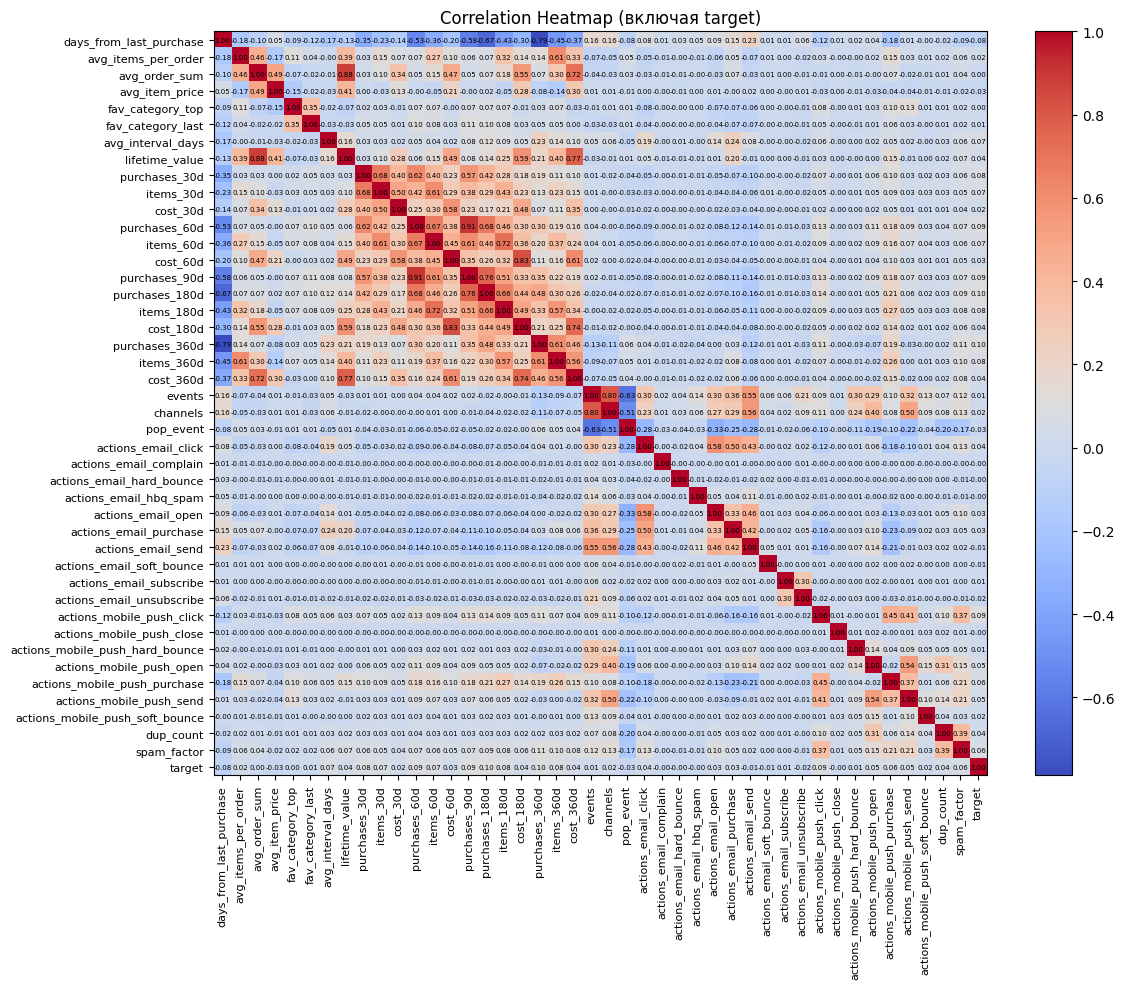

'=== VIF ==='

,feature,VIF
11,purchases_60d,9.721518
2,avg_order_sum,9.255327
17,cost_180d,8.775284
7,lifetime_value,8.308589
14,purchases_90d,8.221778
20,cost_360d,7.873829
16,items_180d,6.673822
15,purchases_180d,6.003738
13,cost_60d,5.876269
12,items_60d,5.869091


In [48]:
df_for_train = df.drop(columns=drop_cols)
calc_target_correlations(df_for_train, target_col="target")

vif у этих фич получился не очень... будем убирать по одному (выше уже будет убранный вариант)  
25	messages	4751.468827045559  
24	bulk_campaigns	4557.404604056862  
44	actions_mobile_push_send	86.63033251646662  
35	actions_email_send	37.31511841292837  
17	cost_90d	32.38699214915867  
14	cost_60d	27.655784671292132  
8	churn_flag	23.014173540405533  
16	items_90d	21.396144750100234  
13	items_60d	18.35091376893147  
15	purchases_90d	17.067579757645326  
12	purchases_60d	14.87017587054433  
21	purchases_360d	13.347259333650094  
20	cost_180d	10.067449835369827  

## Обучение модели

### Подготовка

In [49]:
# возьмем часть данных для подбора гиперпараметров и финального теста
df_test = df_for_train.sample(frac=0.05, random_state=RANDOM_STATE)
df_rest = df_for_train.drop(df_test.index)

In [50]:
# разделим на выборки из оставшихся данных
X_train, X_val, y_train, y_val = train_test_split(
    df_rest.drop(['target'], axis=1),
    df_rest['target'],
    test_size=TEST_SIZE,
    stratify=df_rest['target'],
    random_state=RANDOM_STATE
)

# финальный отложенный тест
X_final_test = df_test.drop(['target'], axis=1)
y_final_test = df_test['target']

In [51]:
# сюда будем писать результаты
results = {}

In [52]:
# Разделяем признаки
cat_selector = make_column_selector(dtype_include=["object", "category"])
num_selector = make_column_selector(dtype_exclude=["object", "category"])

In [53]:
cat_cols = cat_selector(X_train)
num_cols = num_selector(X_train)

display("Категориальные:", cat_cols)
display("Числовые:", num_cols)

'Категориальные:'

['pop_event']

'Числовые:'

['days_from_last_purchase',
 'avg_items_per_order',
 'avg_order_sum',
 'avg_item_price',
 'fav_category_top',
 'fav_category_last',
 'avg_interval_days',
 'lifetime_value',
 'purchases_30d',
 'items_30d',
 'cost_30d',
 'purchases_60d',
 'items_60d',
 'cost_60d',
 'purchases_90d',
 'purchases_180d',
 'items_180d',
 'cost_180d',
 'purchases_360d',
 'items_360d',
 'cost_360d',
 'events',
 'channels',
 'actions_email_click',
 'actions_email_complain',
 'actions_email_hard_bounce',
 'actions_email_hbq_spam',
 'actions_email_open',
 'actions_email_purchase',
 'actions_email_send',
 'actions_email_soft_bounce',
 'actions_email_subscribe',
 'actions_email_unsubscribe',
 'actions_mobile_push_click',
 'actions_mobile_push_close',
 'actions_mobile_push_hard_bounce',
 'actions_mobile_push_open',
 'actions_mobile_push_purchase',
 'actions_mobile_push_send',
 'actions_mobile_push_soft_bounce',
 'dup_count',
 'spam_factor']

In [54]:
to_str = FunctionTransformer(lambda x: x.astype(str))

# для линейных моделей
preprocessor_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("scaler", StandardScaler())
        ]), num_selector),
        ("cat", Pipeline([
            ("to_str", to_str),
            ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))
        ]), cat_selector)
    ]
)

# для деревьев и бустингов
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_selector),
        ("cat", Pipeline([
            ("to_str", to_str),
            ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_selector)
    ]
)

In [55]:
models = {
    "LogisticRegression": (lambda: LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight="balanced"), preprocessor_linear),
    "RandomForest": (lambda: RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, class_weight="balanced"), preprocessor_tree),
    # "DecisionTree": (lambda: DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"), preprocessor_tree), # убрал потому что 2+ часа обучение.... О_о
    "LightGBM": (lambda: LGBMClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=-1), preprocessor_tree),
    "XGBoost": (lambda: XGBClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=0, use_label_encoder=False), preprocessor_tree),
    "CatBoost": (lambda: CatBoostClassifier(random_state=RANDOM_STATE, task_type="CPU", thread_count=N_JOBS, verbose=0), preprocessor_tree),
}


In [56]:
param_grid = {
    "LogisticRegression": {
        "C": (0.0005, 40, "log")
    },
    "RandomForest": {
        "n_estimators": (100, 3000, 50),
        "max_depth": (3, 6800),
        "min_samples_split": (2, 20),
        "min_samples_leaf": (1, 10),
        "max_features": ["sqrt", "log2", None]
    },
    "DecisionTree": {
        "max_depth": (3, 80),
        "min_samples_split": (2, 20),
        "min_samples_leaf": (1, 10),
        "max_features": ["sqrt", "log2", None]
    },
    "LightGBM": {
        "n_estimators": (100, 4000, 50),
        "max_depth": (3, 80),
        "learning_rate": (0.0025, 0.6, "log"),
        "num_leaves": (20, 512),
        "min_child_samples": (5, 100)
    },
    "XGBoost": {
        "n_estimators": (100, 4000, 50),
        "max_depth": (3, 80),
        "learning_rate": (0.0025, 0.6, "log"),
        "subsample": (0.25, 1.0),
        "colsample_bytree": (0.25, 1.0)
    },
    "CatBoost": {
        "iterations": (100, 2000, 50),
        "depth": (3, 20),
        "learning_rate": (0.005, 0.3, "log"),
        "l2_leaf_reg": (1, 10)
    }
}


In [57]:
def objective_model(trial, model_name, preprocessor):
    # train/val split внутри trial
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train,
        test_size=0.25,
        stratify=y_train,
        random_state=RANDOM_STATE
    )

    # SelectKBest
    k_best = trial.suggest_int("selectkbest__k", 1, X_train.shape[1])

    # Настройка модели
    pgrid = param_grid[model_name]

    if model_name == "LogisticRegression":
        C = suggest_param(trial, "C", pgrid["C"])
        model = LogisticRegression(
            C=C,
            random_state=RANDOM_STATE,
            max_iter=1000,
            class_weight="balanced"
        )

    elif model_name in ["RandomForest", "DecisionTree"]:
        cls = RandomForestClassifier if model_name == "RandomForest" else DecisionTreeClassifier
        model_params = {}
        for key, spec in pgrid.items():
            model_params[key] = suggest_param(trial, key, spec)
        model_params["random_state"] = RANDOM_STATE
        if model_name == "RandomForest":
            model_params["n_jobs"] = N_JOBS
        model_params["class_weight"] = "balanced"
        model = cls(**model_params)

    elif model_name in ["LightGBM", "XGBoost", "CatBoost"]:
        cls = {"LightGBM": LGBMClassifier, "XGBoost": XGBClassifier, "CatBoost": CatBoostClassifier}[model_name]
        model_params = {}
        for key, spec in pgrid.items():
            model_params[key] = suggest_param(trial, key, spec)
        model_params["random_state"] = RANDOM_STATE

        if model_name == "LightGBM":
            model_params["n_jobs"] = N_JOBS
            model_params["verbosity"] = -1
            model_params["class_weight"] = "balanced"
        elif model_name == "XGBoost":
            model_params["n_jobs"] = N_JOBS
            model_params["verbosity"] = 0
            model_params["use_label_encoder"] = False
            scale_pos_weight = (y_tr == 0).sum() / max(1, (y_tr == 1).sum())
            model_params["scale_pos_weight"] = scale_pos_weight
        else:  # CatBoost
            model_params["task_type"] = "CPU"
            model_params["thread_count"] = N_JOBS
            model_params["verbose"] = 0
            class_weight = [1.0, float((y_tr == 0).sum() / max(1, (y_tr == 1).sum()))]
            model_params["class_weights"] = class_weight

        model = cls(**model_params)

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("selectkbest", SelectKBest(score_func=f_classif, k=k_best)),
        ("classifier", model)
    ])

    pipeline.fit(X_tr, y_tr)
    y_pred = pipeline.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)

    trial.report(auc, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return auc


### Подбор лучшей модели

In [58]:
best_models = {}
study_results = []

early_stop_cb = EarlyStoppingCallback(patience=EARLY_STOP)

def log_every_N_trials(study, trial, N=50):
    if trial.number % N == 0:
        best_trial = study.best_trial
        logger.info(
            f"[Trial {trial.number}] is best: ROC_AUC={best_trial.value:.4f}, params={best_trial.params}"
        )

for model_name, (model_factory, preprocessor) in models.items():
    logger.info(f"\n\n=== Optimizing {model_name} ===")

    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0)
    study = optuna.create_study(direction="maximize", pruner=pruner)

    study.optimize(
        lambda trial: objective_model(trial, model_name, preprocessor),
        n_trials=N_ITER,
        callbacks=[log_every_N_trials, early_stop_cb]
    )

    best_params = study.best_params
    best_value = study.best_value
    logger.info(f"Best trial {study.best_trial.number} -> ROC_AUC={best_value:.4f}, params={best_params}")

    # Финальный пайплайн
    k_best_final = best_params.get("selectkbest__k", X_train.shape[1])
    final_pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("selectkbest", SelectKBest(score_func=f_classif, k=k_best_final)),
        ("classifier", model_factory())
    ])

    # Применяем параметры к классификатору
    model_params = {k.replace("classifier__", ""): v for k, v in best_params.items() if k.startswith("classifier__")}
    if model_params:
        final_pipe.named_steps["classifier"].set_params(**model_params)

    final_pipe.fit(X_train, y_train)
    best_models[model_name] = final_pipe

    study_results.append({
        "Model": model_name,
        "Best_params": best_params,
        "ROC_AUC_CV": best_value
    })


2025-10-05 11:01:41 [INFO] __main__: 

=== Optimizing LogisticRegression ===
2025-10-05 11:01:42 [INFO] __main__: [Trial 0] is best: ROC_AUC=0.7325, params={'selectkbest__k': 25, 'C': 6.8095583643689475}
2025-10-05 11:02:13 [INFO] __main__: [Trial 50] is best: ROC_AUC=0.7328, params={'selectkbest__k': 27, 'C': 31.576915131635563}
2025-10-05 11:02:39 [INFO] __main__: [Trial 100] is best: ROC_AUC=0.7329, params={'selectkbest__k': 24, 'C': 3.7551813147476287}
2025-10-05 11:03:07 [INFO] __main__: [Trial 150] is best: ROC_AUC=0.7329, params={'selectkbest__k': 24, 'C': 4.67367855809463}
2025-10-05 11:03:35 [INFO] __main__: [Trial 200] is best: ROC_AUC=0.7329, params={'selectkbest__k': 24, 'C': 0.7135984565823436}
2025-10-05 11:03:35 [INFO] func: Ранняя остановка: нет улучшений 200 trials
2025-10-05 11:03:35 [INFO] __main__: Best trial 171 -> ROC_AUC=0.7329, params={'selectkbest__k': 24, 'C': 0.7135984565823436}
2025-10-05 11:03:36 [INFO] __main__: 

=== Optimizing RandomForest ===
2025-10-05

### Сравнение результатов

In [59]:
for res in study_results:
    name = res["Model"]
    model = best_models[name]

    # Предсказания вероятностей
    y_val_pred = model.predict_proba(X_val)[:, 1]
    y_test_pred = model.predict_proba(X_final_test)[:, 1]

    # ROC-AUC
    res["ROC_AUC_Val"] = roc_auc_score(y_val, y_val_pred)
    res["ROC_AUC_FinalTest"] = roc_auc_score(y_final_test, y_test_pred)

    # Бинарные предсказания (порог 0.5)
    y_test_bin = (y_test_pred >= 0.5).astype(int)

    cm = confusion_matrix(y_final_test, y_test_bin)
    cm_df = pd.DataFrame(
        cm,
        index=["0", "1"],
        columns=["0", "1"]
    )

    logger.info(f"=== {name} ===")
    display(cm_df.style.set_caption("Confusion Matrix"))
    logger.info("-" * 50)

# Сводная таблица по ROC-AUC
results_df = pd.DataFrame(study_results)
display(results_df.sort_values("ROC_AUC_FinalTest", ascending=False))

2025-10-05 11:03:51 [INFO] __main__: === LogisticRegression ===


,0,1
0,1836,598
1,23,35


2025-10-05 11:03:51 [INFO] __main__: --------------------------------------------------
2025-10-05 11:03:51 [INFO] __main__: === RandomForest ===


,0,1
0,2433,1
1,58,0


2025-10-05 11:03:51 [INFO] __main__: --------------------------------------------------
2025-10-05 11:03:51 [INFO] __main__: === LightGBM ===


,0,1
0,2432,2
1,57,1


2025-10-05 11:03:51 [INFO] __main__: --------------------------------------------------
2025-10-05 11:03:51 [INFO] __main__: === XGBoost ===


,0,1
0,2432,2
1,58,0


2025-10-05 11:03:51 [INFO] __main__: --------------------------------------------------
2025-10-05 11:03:51 [INFO] __main__: === CatBoost ===


,0,1
0,2434,0
1,58,0


2025-10-05 11:03:51 [INFO] __main__: --------------------------------------------------


,Model,Best_params,ROC_AUC_CV,ROC_AUC_Val,ROC_AUC_FinalTest
0,LogisticRegression,"{'selectkbest__k': 24, 'C': 0.7135984565823436}",0.732869,0.770467,0.780856
1,RandomForest,"{'selectkbest__k': 22, 'n_estimators': 1100, '...",0.690213,0.697564,0.761415
4,CatBoost,"{'selectkbest__k': 19, 'iterations': 450, 'dep...",0.645407,0.723817,0.760852
2,LightGBM,"{'selectkbest__k': 31, 'n_estimators': 1450, '...",0.622039,0.709930,0.714285
3,XGBoost,"{'selectkbest__k': 25, 'n_estimators': 3650, '...",0.500000,0.631354,0.703560


### Значимость признаков

In [60]:
def get_feature_names(preprocessor):
    """Получаем имена фичей из ColumnTransformer."""
    feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if transformer == "drop":
            continue

        if isinstance(transformer, Pipeline):
            last_step = transformer.steps[-1][1]
            if hasattr(last_step, "get_feature_names_out"):
                try:
                    feature_names.extend(last_step.get_feature_names_out(cols))
                except TypeError:
                    feature_names.extend(last_step.get_feature_names_out())
            else:
                feature_names.extend(cols)

        elif hasattr(transformer, "get_feature_names_out"):
            try:
                feature_names.extend(transformer.get_feature_names_out(cols))
            except TypeError:
                feature_names.extend(transformer.get_feature_names_out())

        elif transformer == "passthrough":
            feature_names.extend(cols)

        else:
            feature_names.extend(cols)

    return feature_names

In [61]:
best_row = results_df.sort_values("ROC_AUC_FinalTest", ascending=False).iloc[0]
best_model_name = best_row["Model"]
best_model = best_models[best_model_name]

logger.info(f"=== Анализ признаков и SHAP для лучшей модели: {best_model_name} ===")

preprocessor = best_model.named_steps["preprocessor"]
selector = best_model.named_steps["selectkbest"]

all_features = get_feature_names(preprocessor)

mask = selector.get_support()
selected_features = np.array(all_features)[mask]

logger.info(f"Выбрано признаков: {len(selected_features)}")
logger.info(f"Top features: {selected_features[:15]}")

2025-10-05 11:03:51 [INFO] __main__: === Анализ признаков и SHAP для лучшей модели: LogisticRegression ===
2025-10-05 11:03:51 [INFO] __main__: Выбрано признаков: 24
2025-10-05 11:03:51 [INFO] __main__: Top features: ['days_from_last_purchase' 'avg_item_price' 'avg_interval_days'
 'lifetime_value' 'purchases_30d' 'items_30d' 'purchases_60d' 'items_60d'
 'cost_60d' 'purchases_90d' 'purchases_180d' 'items_180d' 'cost_180d'
 'purchases_360d' 'items_360d']


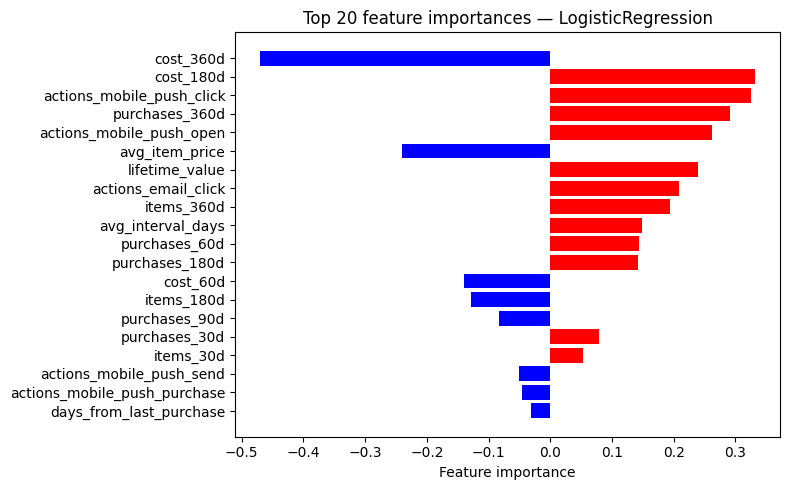

2025-10-05 11:03:51 [INFO] __main__: Вычисление SHAP для LogisticRegression...
2025-10-05 11:03:51 [INFO] __main__: Топ-20 признаков по SHAP: ['purchases_360d', 'cost_360d', 'actions_mobile_push_open', 'actions_mobile_push_click', 'actions_email_click', 'avg_item_price', 'cost_180d', 'lifetime_value', 'items_360d', 'purchases_180d', 'purchases_60d', 'avg_interval_days', 'items_180d', 'purchases_90d', 'actions_mobile_push_send', 'cost_60d', 'purchases_30d', 'days_from_last_purchase', 'actions_mobile_push_purchase', 'items_30d']


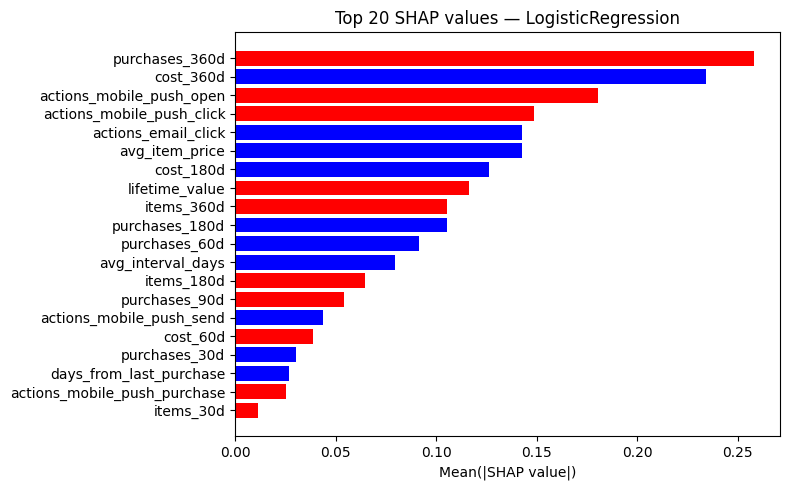

2025-10-05 11:03:51 [INFO] __main__: Построение SHAP Beeswarm Plot...


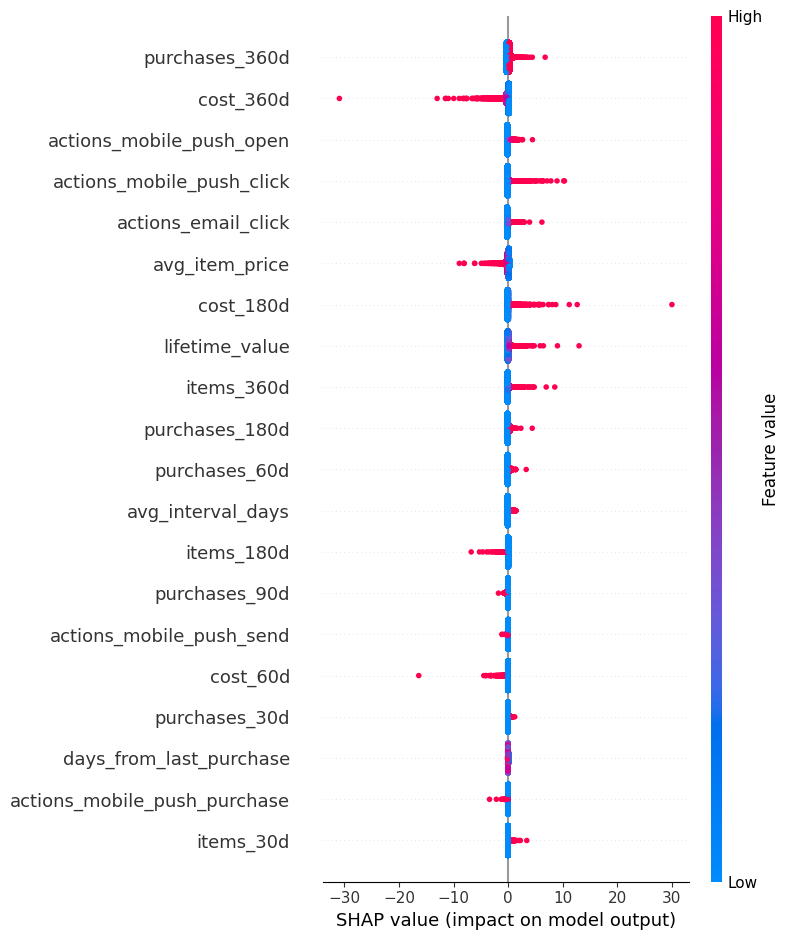

2025-10-05 11:03:54 [INFO] __main__: SHAP-анализ завершён для LogisticRegression


In [ ]:
N = 20 # число фич для отображения нпа графиках

classifier = list(best_model.named_steps.values())[-1]

feature_importance = None
if hasattr(classifier, "feature_importances_"):
    feature_importance = pd.DataFrame({
        "feature": selected_features,
        "importance": classifier.feature_importances_
    }).sort_values("importance", ascending=False)
elif hasattr(classifier, "coef_"):
    coefs = classifier.coef_[0]
    feature_importance = pd.DataFrame({
        "feature": selected_features,
        "importance": coefs
    }).sort_values("importance", key=np.abs, ascending=False)

if feature_importance is not None:
    top_features = feature_importance.head(N)
    plt.figure(figsize=(8, 5))
    colors = ['red' if val > 0 else 'blue' for val in top_features["importance"]]
    plt.barh(top_features["feature"], top_features["importance"], color=colors)
    plt.gca().invert_yaxis()
    plt.title(f"Top {N} feature importances — {best_model_name}")
    plt.xlabel("Feature importance")
    plt.tight_layout()
    plt.show()

logger.info(f"Вычисление SHAP для {best_model_name}...")

X_train_transformed = preprocessor.transform(X_train)
X_train_selected = selector.transform(X_train_transformed)
X_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
explainer = shap.Explainer(classifier, X_selected_df)
shap_values = explainer(X_selected_df)

shap_importance = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": selected_features,
    "mean_abs_shap": shap_importance
}).sort_values("mean_abs_shap", ascending=False)

top_shap_features = shap_df.head(N)["feature"].tolist()
logger.info(f"Топ-{N} признаков по SHAP: {top_shap_features}")

plt.figure(figsize=(8, 5))
bar_colors = ['red' if val > 0 else 'blue' for val in shap_values[:, [list(selected_features).index(f) for f in top_shap_features]].values.mean(axis=0)]
plt.barh(top_shap_features[::-1], shap_df.set_index("feature").loc[top_shap_features]["mean_abs_shap"][::-1], color=bar_colors[::-1])
plt.title(f"Top {N} SHAP values — {best_model_name}")
plt.xlabel("Mean(|SHAP value|)")
plt.tight_layout()
plt.show()

logger.info("Построение SHAP Beeswarm Plot...")
shap.summary_plot(
    shap_values[:, [list(selected_features).index(f) for f in top_shap_features]],
    features=X_selected_df[top_shap_features],
    feature_names=top_shap_features,
    plot_type="dot",
    color_bar=True,
    show=True
)

logger.info(f"SHAP-анализ завершён для {best_model_name}")


2025-10-05 11:03:54 [INFO] __main__: Permutation Importance (важность признаков)


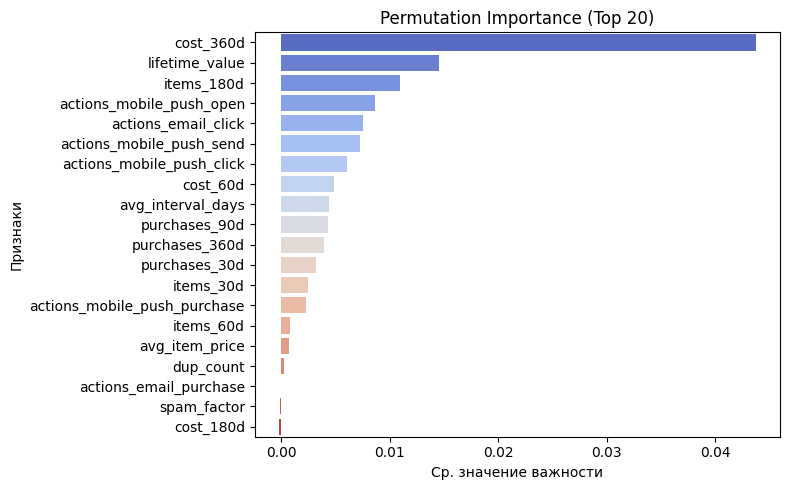

In [63]:
logger.info("Permutation Importance (важность признаков)")

perm_importance = permutation_importance(
    classifier,
    X_selected_df,
    y_train,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_df = pd.DataFrame({
    "feature": selected_features,
    "importance": perm_importance.importances_mean
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=perm_df.head(N),
    x="importance",
    y="feature",
    hue="feature",
    palette="coolwarm",
    dodge=False,
    legend=False
)
plt.title(f"Permutation Importance (Top {N})")
plt.xlabel("Ср. значение важности")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()